# **Tarea Nº 4**
Scope: APIs

Curso:          Fundamentos de Programación en Python para Macroeconomía y Finanzas     
Profesor:       Victor Fuentes Campos     

- Fecha y hora de entrega: Viernes 12 de enero, 11:59pm
- Agregue los nombres de las personas con las que discutió esta tarea: ____ Luis Cahuana ______
- Envíe su tarea haciendo el `push` de su código a su repo en GitHub Classroom: 

The Central Bank Reserve of Perú (BCRP) holds a list of datasets that are among the most comprehensive for macroeconomic purposes. In this exercise, we'll retrieve data from the [BCRP API](https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api) and explore the impact of pandemics

## Before starting

- You must pull the necessary data using `get` and `requests`
- You are required to apply the concepts learned in the previous sessions (`pandas`, `if`, `loop`, `function`)
- Hint: here is the BCRP url structure for the APIs call:
```html
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[códigos de series]/[formato de salida]/[periodo inicial]/[periodo final]/[idioma]
```

## The very long run

1. Locate the "Estadísticas de 100 años del BCRP" section in the BCRP´s series data statistics [here](https://estadisticas.bcrp.gob.pe/estadisticas/series/index) and identify the necessary code for the serie **`PBI (Mill S/ 2007)`**. Later, add manually the annual GDP values for 2022 and 2023 (be careful with the units of data). Then, **calculate** the Peruvian annual GDP growth (%) since 1922 to 2023. Finally, plot it using a very simple graph through `matplotlib` and provide critical insights (no more than 100 words)

    Hint1: use `.json()` for exploring the `content`. Your data is inside `["periods"]`
    
    Hint2: the graph must looks something like this: <img src="growth_gdp_long_run.png" max-width="300">
    

In [8]:
import requests
response = requests.get("https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD39552DA/json/1922/2021")
status_code = response.status_code 

response1 = requests.get("https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PN01728AM/json/2022/2023") # La data de 2023 se encuentra incompleta, por eso la obvio.
status_code1 = response1.status_code

data = response.json()
data1 = response1.json()

# Promedio de la variación porcentual del PBI en response1
variation_values_2022 = [float(period["values"][0]) for period in data1["periods"]]
average_variation_2022 = sum(variation_values_2022) / len(variation_values_2022)

data2 = {
    "config": data["config"],
    "periods": data["periods"] + [{"name": "2022", "values": [str(average_variation_2022)]}]
}

data3 = {
    "config": data2["config"],
    "periods": data2["periods"] + [{"name": "2023", "values": ["-0.5"]}]
}


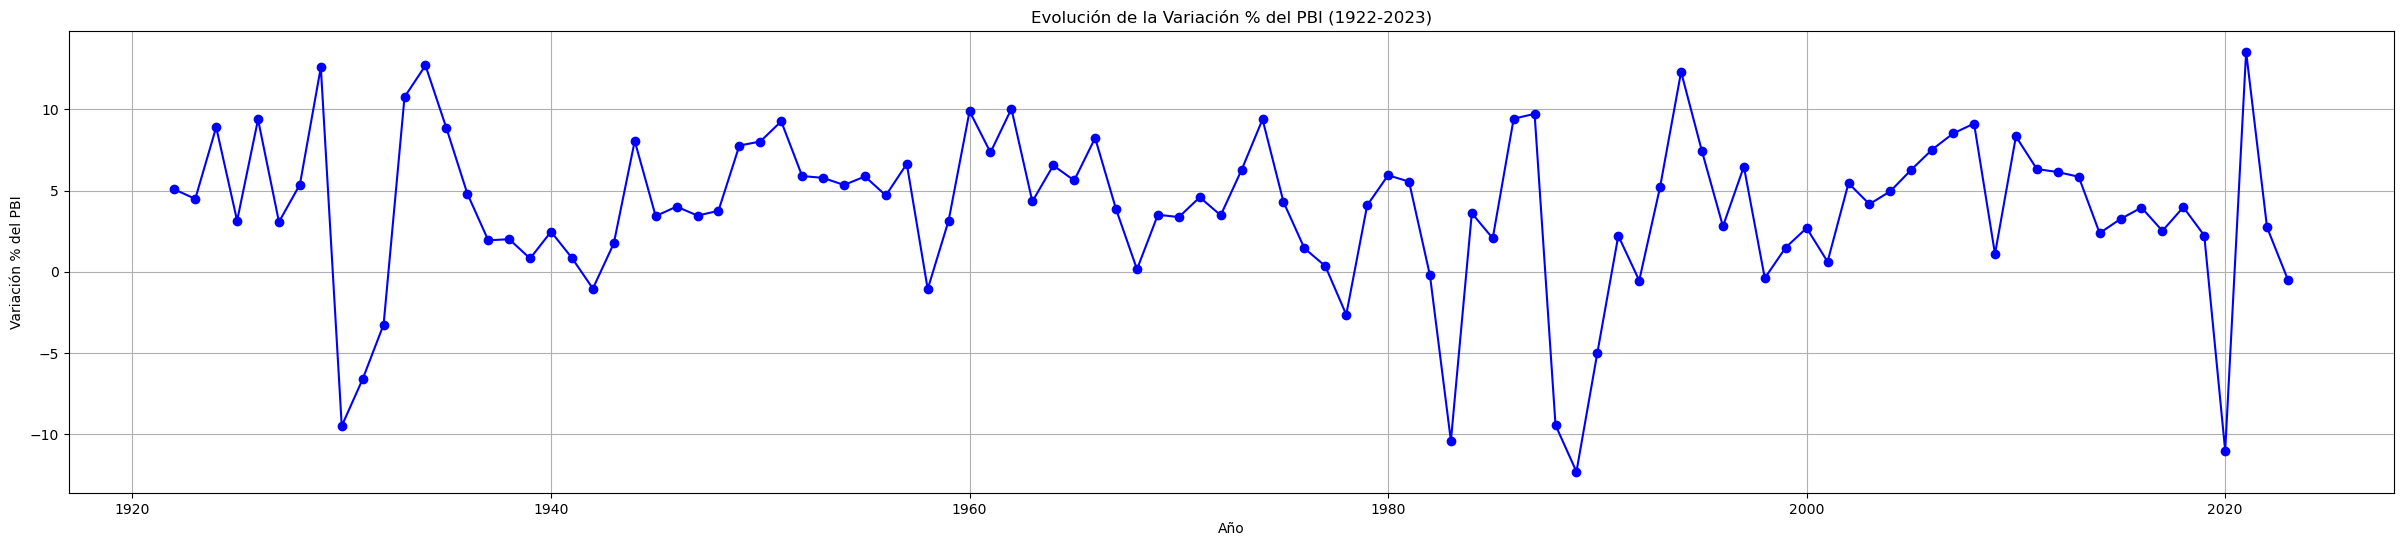

In [10]:
import matplotlib.pyplot as plt
# Listas
años = [int(period["name"]) for period in data3["periods"]]
variaciones = [float(period["values"][0]) for period in data3["periods"]]

# Grafica y titulos a los ejes 
plt.figure(figsize=(30, 6))
plt.plot(años, variaciones, marker='o', linestyle='-', color='b')
plt.title('Evolución de la Variación % del PBI (1922-2023)')
plt.xlabel('Año')
plt.ylabel('Variación % del PBI')
plt.grid(True)
plt.show()

## The hitman

2. Retrieve the up-to-date data for the monthly GDP in index (2007=100) from this [link](https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/producto-bruto-interno-y-demanda-interna-variaciones-indice-2007). Then, calculate the the 5-year average monthly growth previous to the pandemics (ending in Feb-2020) for the 12-month rolling mean of the index, and project the alternative scenario of the Peruvian economy without the COVID-19. Then plot them out and provide insight from the gap between the real data and the pre-pandemic trend.

    Hint1: You may use the regression type of your election, but the OLS is recommended. 
    
    Hint2: Your plot should look somethig like this. You aren´t required to add flags/annotations/texts inside the graph <img src="growth_gdp_pandemics.png" max-width="300">

    Hint3: For more details about calculation, review this post from [The Economist](https://www.economist.com/graphic-detail/2021/10/28/americas-post-covid-economic-recovery-suffers-a-setback)
    


In [16]:
# Solution
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

In [20]:
import requests
import pandas as pd

URL = 'https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/resultados/PN01770AM/html'

response = requests.get(URL, verify=False)  # Desactiva la verificación SSL
BCRP = pd.read_html(response.content)
serie = BCRP[1]
print(serie)

     Fecha  Producto bruto interno y demanda interna (índice 2007=100) - PBI
0    Ene03                                               73.2               
1    Feb03                                               71.1               
2    Mar03                                               74.3               
3    Abr03                                               80.7               
4    May03                                               83.2               
..     ...                                                ...               
245  Jun23                                              177.3               
246  Jul23                                              175.5               
247  Ago23                                              178.1               
248  Sep23                                              180.0               
249  Oct23                                              181.4               

[250 rows x 2 columns]


c:\Users\User\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'estadisticas.bcrp.gob.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [23]:
#Exploramos la base
prepandemia = serie[145:207].copy()  
#se añade una columna "tiempo"
prepandemia.loc[:, 'Tiempo'] = range(1, len(prepandemia) + 1)
#Reiniciamos los índices del DataFrame:
prepandemia = prepandemia.reset_index(drop=True)

#serie contrafactual
prepandemia_contrafactual=serie[145:251].copy()  

prepandemia_contrafactual.loc[:, 'Tiempo'] = range(1, len(prepandemia_contrafactual) + 1)

#Indices del DataFrame:
prepandemia_contrafactual = prepandemia_contrafactual.reset_index(drop=True)

#Ajustamos los datos por estacionalidad
# crecimiento mensual de la serie
prepandemia_contrafactual['Log_PBI'] = np.log1p(prepandemia_contrafactual['Producto bruto interno y demanda interna (índice 2007=100) - PBI'])
prepandemia_contrafactual #lo visualizamos

#Se suaviza las fluctuaciones
prepandemia['Crecimiento mensual'] = prepandemia['Producto bruto interno y demanda interna (índice 2007=100) - PBI'].pct_change() * 100

prepandemia['Media_movil'] = prepandemia['Crecimiento mensual'].rolling(window=12).mean()
prepandemia



,Fecha,Producto bruto interno y demanda interna (índice 2007=100) - PBI,Tiempo,Crecimiento mensual,Media_movil
0,Feb15,137.5,1,NaN,NaN
1,Mar15,148.3,2,7.854545,NaN
2,Abr15,152.0,3,2.494943,NaN
3,May15,150.2,4,-1.184211,NaN
4,Jun15,150.6,5,0.266312,NaN
...,...,...,...,...,...
57,Nov19,174.2,58,-1.191151,0.392502
58,Dic19,189.6,59,8.840413,0.296849
59,Ene20,162.4,60,-14.345992,0.436820
60,Feb20,161.8,61,-0.369458,0.543860


In [27]:
regresion = sm.OLS(prepandemia['Producto bruto interno y demanda interna (índice 2007=100) - PBI'], sm.add_constant(prepandemia['Tiempo'])).fit()
prepandemia['tendencia_anterior'] = regresion.predict(sm.add_constant(prepandemia['Tiempo'])) 

postpandemia = pd.DataFrame({'X': np.arange(1, 106)})
postpandemia['Y'] = regresion.predict(sm.add_constant(postpandemia['X']))

#Se aplica el log para desestabilizar
postpandemia['Log_Y'] = np.log1p(postpandemia['Y'])
postpandemia

,X,Y,Log_Y
0,1,150.239478,5.018865
1,2,150.604973,5.021278
2,3,150.970469,5.023686
3,4,151.335965,5.026088
4,5,151.701461,5.028485
...,...,...,...
100,101,186.789048,5.235319
101,102,187.154544,5.237264
102,103,187.520040,5.239204
103,104,187.885535,5.241141


GRAFICO

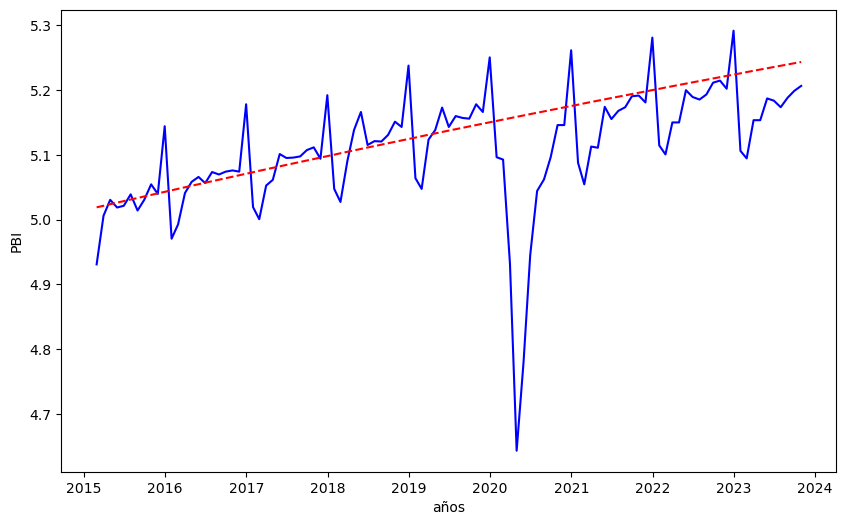

In [31]:
import matplotlib.dates as mdates
#columna de "tiempo"
prepandemia_contrafactual['Tiempo'] = pd.date_range(start='2015-02-01', periods=len(prepandemia_contrafactual), freq='M')
postpandemia['X'] = pd.date_range(start='2015-02-01', periods=len(postpandemia), freq='M')
# Convertir 'Tiempo' y 'X' a objetos de fecha y hora
prepandemia_contrafactual['Tiempo'] = pd.to_datetime(prepandemia_contrafactual['Tiempo'])
postpandemia['X'] = pd.to_datetime(postpandemia['X'])

#Comparamos
plt.figure(figsize=(10, 6))
plt.plot(prepandemia_contrafactual['Tiempo'], prepandemia_contrafactual['Log_PBI'], label='PBI', color='blue')
plt.plot(postpandemia['X'], postpandemia['Log_Y'], label='Tendencia anterior a la etapa de pandemia(OLS)', linestyle='--', color='red')

# Formatea a los ejes
axes = plt.gca()
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes.xaxis.set_major_locator(mdates.YearLocator())



plt.xlabel('años')
plt.ylabel('PBI')
plt.show()

## The winners

- Based on the [Nasdaq Stock Screener](https://www.nasdaq.com/market-activity/stocks/screener), identify the three largest companies in the three larger sectors defined by market cap
- Elaborate a list/dictionary/series (what ever you think is more suitable) containing all tickers (or symbols) and sectors from these companies.
- So far, you can download data from Nasdaq, web scrape it or copy it manually. It doesn´t matter
- Then, use `yfinance` library to retrieve the market data for all the 9 firms
- Construct a table with the most common *institucional holders* by sector. Is there any interesting pattern? Hint: loop the `institutional_holders` from `yfinance`
- Calculate the distribution of the daily percentage returns for the 3 larger companies (defined by market cap) along the last 5 years. Plot your results (feel free to find the most appealing way to represent them) and provide critical insights

$$
  percentage\_return_{t} = \frac{price_t-price_{t-1}}{price_t}*100+dividends (\%)
$$

- Hint1: you can find the `dividens` through the `yfinance`'s 
`Ticker()`
- Hint2: some firms may not be paying dividends

In [ ]:
# Solution